In [1]:
import os
import sys

def add_to_sys_path(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        sys.path.append(dirpath)        
root_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/'
add_to_sys_path(root_dir)

from FFNNmodel import FeedforwardNeuralNetwork, ffnn_train, ffnn_evaluate, ffnn_predict
from neural_audio_dataset import NeuralAudioDataset
import utils.audio_utils as au
import utils.encodec_utils as eu
import utils.signal_utils as su
import utils.train_utils as tu
import utils.visualization_utils as vu

import argparse
import json
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import mean_squared_error
from scipy import stats
import ast

exec(open('/home/jovyan/pablo_tostado/bird_song/enSongDec/utils/all_imports.py').read())

In [2]:
# Directory path
models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/models_checkpoints/'
model_extension = '.pt'  # Change this to the extension you want

# Filter files based on the extension
model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]

# Print the filtered files
# print(len(filtered_files), filtered_files)

In [3]:
# Load models CSV info file
info_path = os.path.join(models_checkpoints_dir, 'models_info.csv')

# Check if the file exists and 
if os.path.isfile(info_path):
    df_models = pd.read_csv(info_path)

df_models['tot_val_err'] = df_models['tot_val_err'].apply(ast.literal_eval)
df_models['tot_train_err'] = df_models['tot_train_err'].apply(ast.literal_eval)


In [4]:
projects = { 
    '1': ['z_w12m7_20', 'ra', 'RAW'], 
    '2': ['z_r12r13_21', 'ra', 'RAW'],  
    '3': ['z_w12m7_20', 'hvc', 'RAW'], 
    '4': ['z_r12r13_21', 'hvc', 'RAW'], 
    '5': ['z_w12m7_20', 'ra', 'TRAJECTORIES'],
    '6': ['z_r12r13_21', 'ra', 'TRAJECTORIES'],
    '7': ['z_w12m7_20', 'hvc', 'TRAJECTORIES'],  
    '8': ['z_r12r13_21', 'hvc', 'TRAJECTORIES']
}

for k, v in projects.items():
    print(k, v)

1 ['z_w12m7_20', 'ra', 'RAW']
2 ['z_r12r13_21', 'ra', 'RAW']
3 ['z_w12m7_20', 'hvc', 'RAW']
4 ['z_r12r13_21', 'hvc', 'RAW']
5 ['z_w12m7_20', 'ra', 'TRAJECTORIES']
6 ['z_r12r13_21', 'ra', 'TRAJECTORIES']
7 ['z_w12m7_20', 'hvc', 'TRAJECTORIES']
8 ['z_r12r13_21', 'hvc', 'TRAJECTORIES']


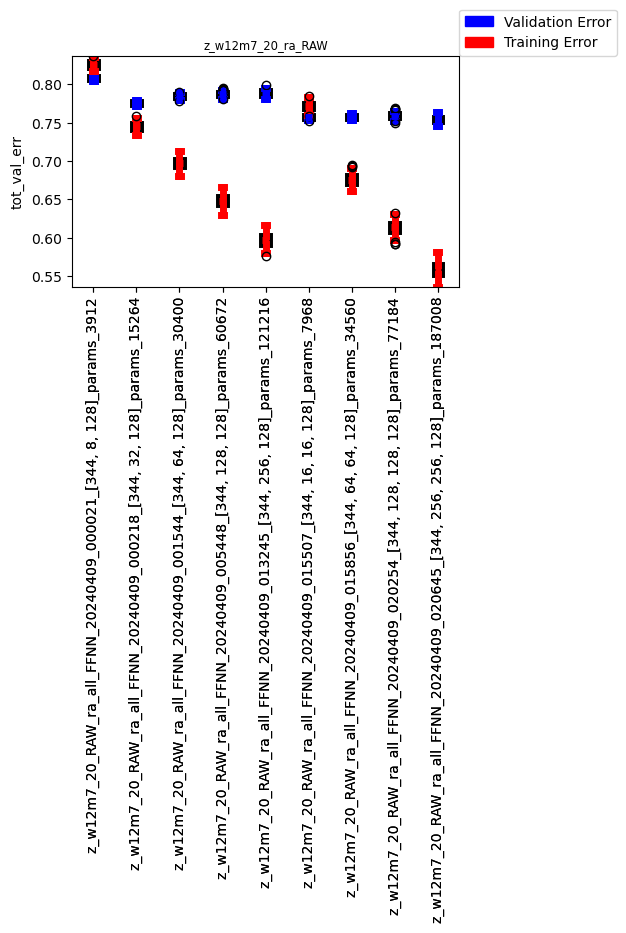

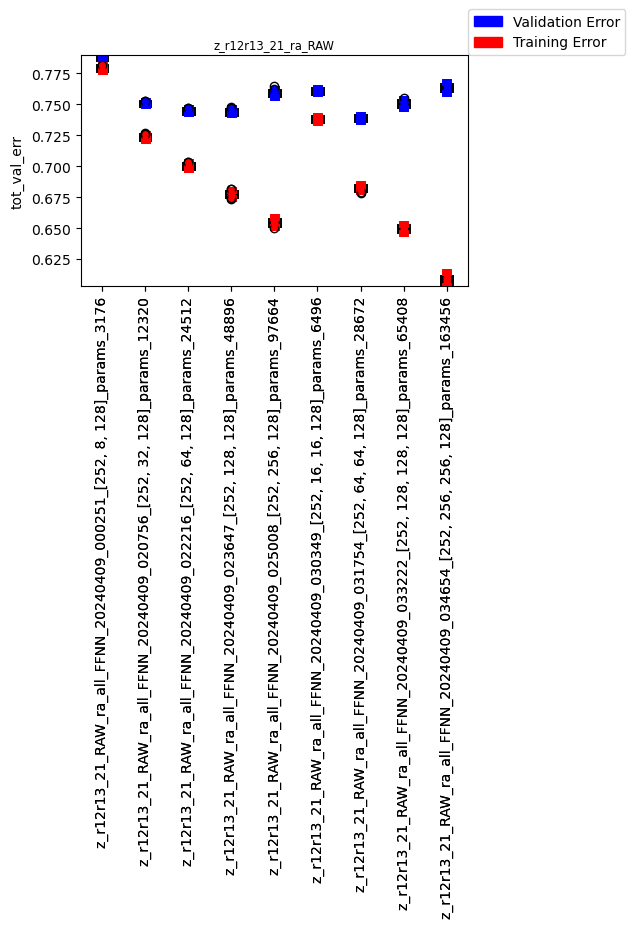

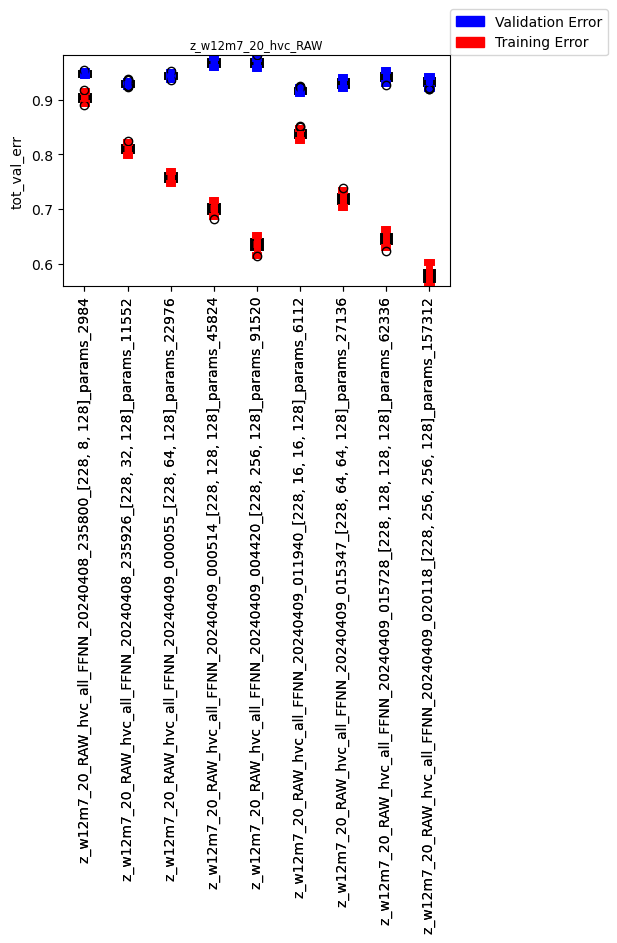

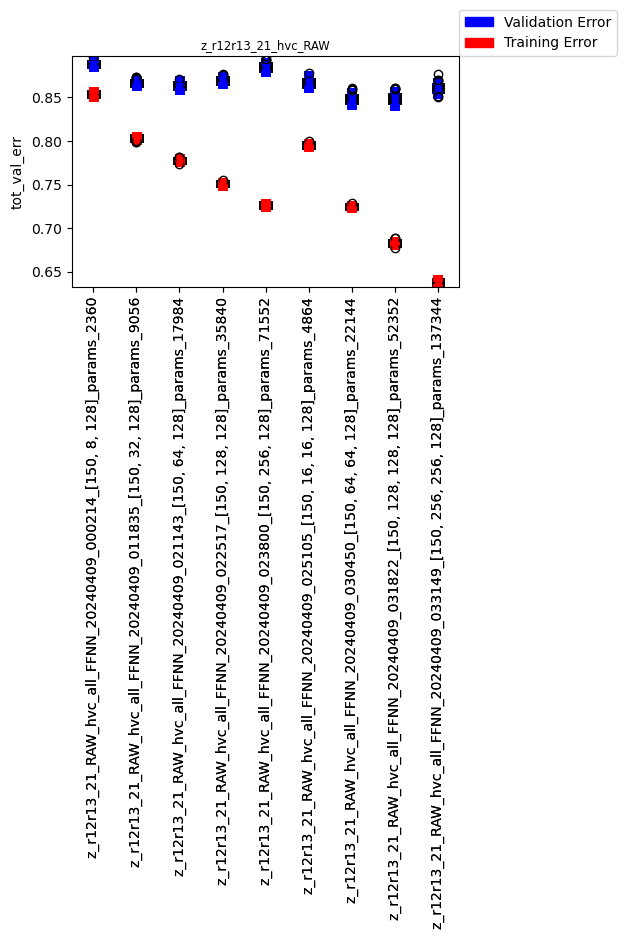

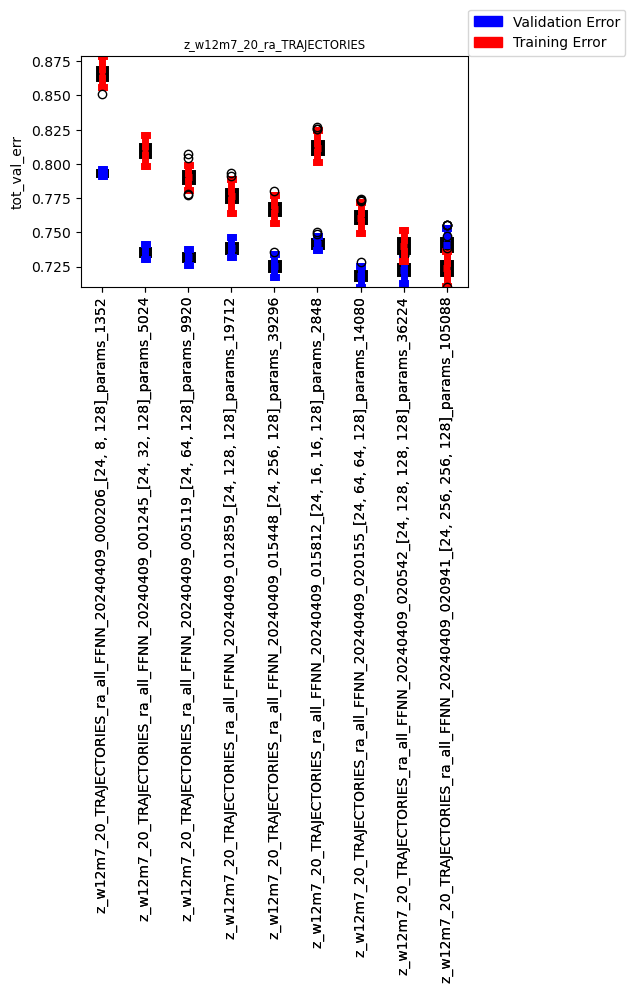

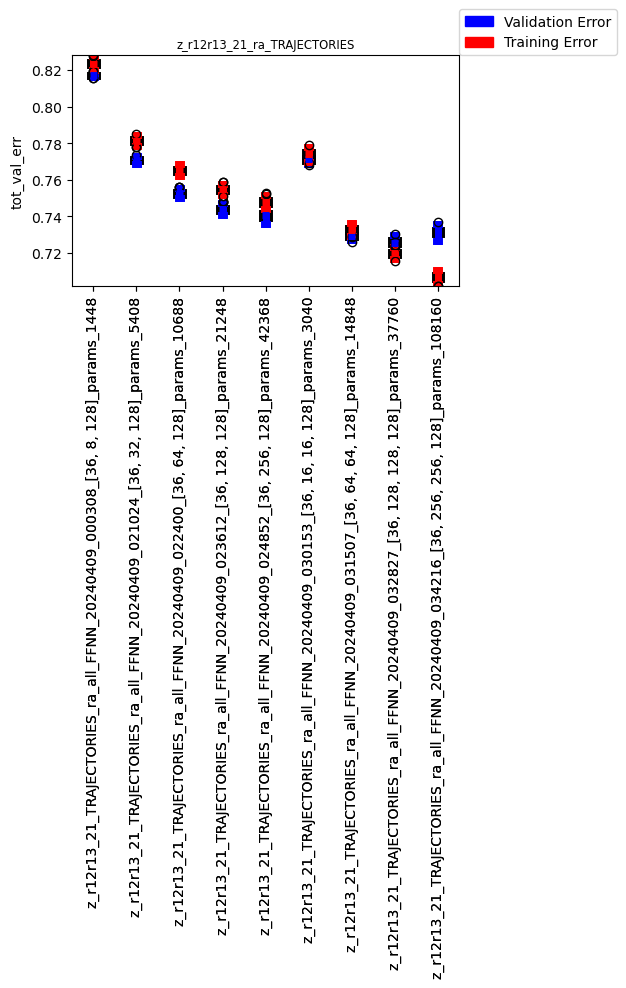

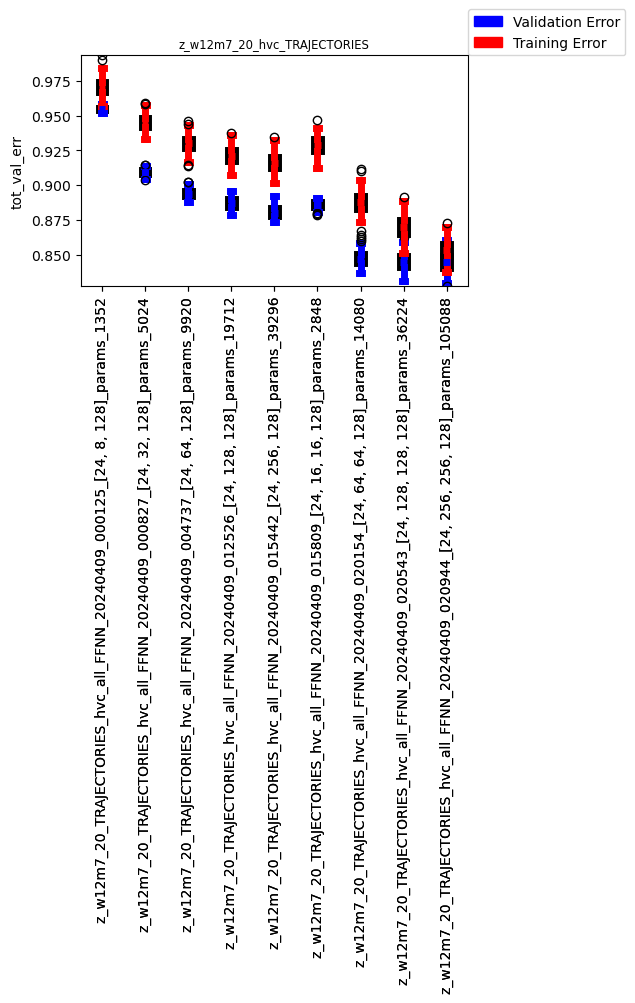

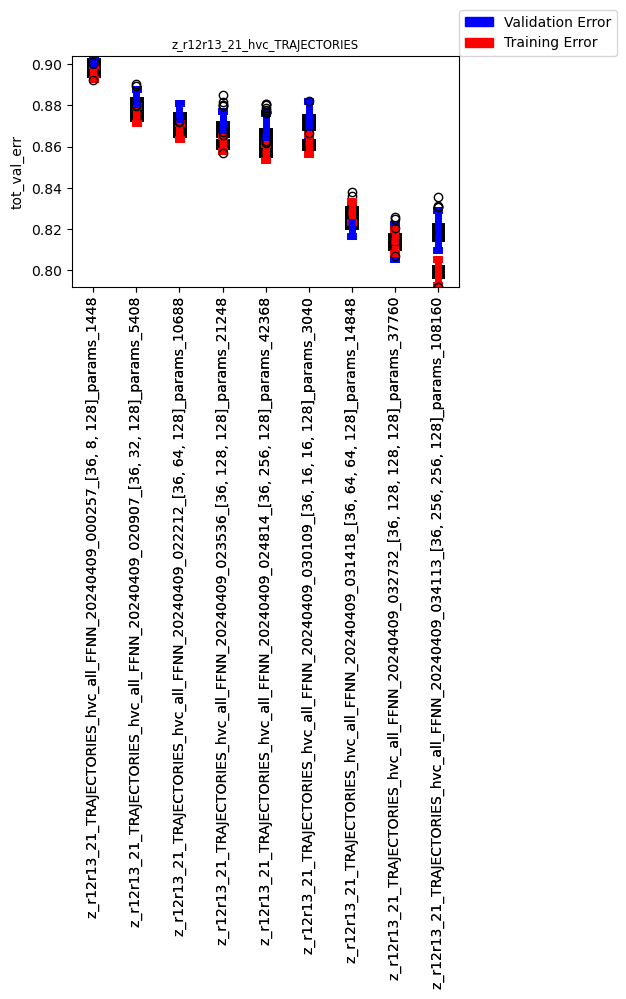

In [5]:
for k, project in projects.items():

    fig, axs = plt.subplots(figsize=(5, 3))
    positions = 1
    x_labels = []
    for loc, m in enumerate(df_models['experiment_name']):
        if all(s in m for s in project):
            
            color, linewidth = 'blue', 5
            axs.boxplot(df_models.loc[loc]['tot_val_err'][-200:], positions=[positions],
                              patch_artist=True, boxprops=dict(facecolor=color, linewidth=linewidth),
                              whiskerprops=dict(color=color, linewidth=linewidth),
                              capprops=dict(color=color, linewidth=linewidth),
                              medianprops=dict(color=color, linewidth=linewidth))
    
            color, linewidth = 'red', 5
            axs.boxplot(df_models.loc[loc]['tot_train_err'][-200:], positions=[positions],
                              patch_artist=True, boxprops=dict(facecolor=color, linewidth=linewidth),
                              whiskerprops=dict(color=color, linewidth=linewidth),
                              capprops=dict(color=color, linewidth=linewidth),
                              medianprops=dict(color=color, linewidth=linewidth))
            positions += 1
            x_labels.append('_'.join([df_models.loc[loc]['experiment_name'], df_models.loc[loc]['layers'], 'params', str(df_models.loc[loc]['total_params'])]))
            x_labels.append('_'.join([df_models.loc[loc]['experiment_name'], df_models.loc[loc]['layers'], 'params', str(df_models.loc[loc]['total_params'])]))
    
    axs.set_xticklabels(x_labels, rotation=90)
    axs.set_ylabel('tot_val_err')
    axs.set_title('_'.join(project))

    # Create custom legend handles
    blue_patch = mpatches.Patch(color='blue', label='Validation Error')
    red_patch = mpatches.Patch(color='red', label='Training Error')
    axs.legend(handles=[blue_patch, red_patch], loc=[1,1])
    plt.show()


In [6]:
# Load models CSV info file
info_path = os.path.join(models_checkpoints_dir, 'models_info.csv')

# Check if the file exists and 
if os.path.isfile(info_path):
    df_models = pd.read_csv(info_path)

df_models['tot_val_err'] = df_models['tot_val_err'].apply(ast.literal_eval)
df_models['tot_train_err'] = df_models['tot_train_err'].apply(ast.literal_eval)

In [7]:
df_models.columns #,df_models['config_id']

Index(['dataset_dir', 'models_checkpoints_dir', 'train_figures_dir',
       'dataset_filename', 'neural_mode', 'nucleus', 'neural_key', 'network',
       'bird', 'date', 'session', 'config_id', 'neural_history_ms',
       'gaussian_smoothing_sigma', 'max_temporal_shift_ms', 'noise_level',
       'transform_probability', 'percent_train', 'percent_test', 'batch_size',
       'learning_rate', 'num_epochs', 'hidden_layer_sizes', 'dropout_prob',
       'experiment_name', 'layers', 'total_params', 'train_idxs', 'test_idxs',
       'tot_train_loss', 'tot_train_err', 'tot_val_loss', 'tot_val_err'],
      dtype='object')

In [8]:
def load_model_statedict(models_checkpoints_dir, model_filename, suffle_inputs=False):
    
    # --------- LOAD EXPERIMENT --------- #
    
    metadata_extension = '.json' 
    metadata_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(metadata_extension)]
    exp_metadata_file = next((file for file in metadata_files if model_filename[:-3] in file), None)
    print(exp_metadata_file)
    
    with open(models_checkpoints_dir + exp_metadata_file, 'rb') as file:
        experiment_metadata = json.load(file)

    # Experiment params
    # dataset_dir = experiment_metadata['dataset_dir']
    dataset_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/data/'
    dataset_filename = experiment_metadata['dataset_filename']
    train_idxs = experiment_metadata['train_idxs']
    test_idxs = experiment_metadata['test_idxs']
    model_layers = experiment_metadata['layers']
    neural_mode = experiment_metadata['neural_mode']
    neural_key = experiment_metadata['neural_key']    
    neural_history_ms = experiment_metadata["neural_history_ms"]
    gaussian_smoothing_sigma = experiment_metadata["gaussian_smoothing_sigma"]    
    max_temporal_shift_ms = experiment_metadata["max_temporal_shift_ms"]
    noise_level = experiment_metadata["noise_level"]
    transform_probability = experiment_metadata["transform_probability"]    
    dropout_prob = experiment_metadata["dropout_prob"]
    batch_size = experiment_metadata["batch_size"]
    learning_rate = experiment_metadata["learning_rate"]
    
    print('train_idxs: ', train_idxs, ' - test_ixs: ', test_idxs, ' - model_layers: ', model_layers)    
    
    # --------- LOAD DATA --------- #
    
    # Open the file in binary read mode ('rb') and load the content using pickle
    with open(dataset_dir + dataset_filename + '.pkl', 'rb') as file:
        data_dict = pkl.load(file)
    
    # Extarct data from dataset
    neural_array = data_dict['neural_dict'][neural_key]
    audio_motifs = data_dict['audio_motifs']
    fs_audio = data_dict['fs_audio']
    fs_neural = data_dict['fs_neural']
    
    # Calculate the duration based on the last dimension of the arrays and their sampling rates
    trial_length_neural = (neural_array.shape[-1] / fs_neural)*1000
    trial_length_audio = (audio_motifs.shape[-1] / fs_audio)*1000
    
    # Check the durations of the neural/audio data are equal and raise a warning if they aren't
    print('Length of neural trials: {} ms, length of audio trials: {} ms. '.format(trial_length_neural, trial_length_audio))
    if trial_length_neural != trial_length_audio:
        warnings.warn("WARNING: Neural data duration and audio motifs duration are different in this dataset!")

    
    # --------- PROCESS AUDIO --------- #
    
    b, a = fh.load_filter_coefficients_matlab(
        '/home/jovyan/pablo_tostado/repos/songbirdcore/songbirdcore/filters/butter_bp_250Hz-8000hz_order4_sr25000.mat')
    audio_motifs = fh.noncausal_filter_2d(audio_motifs, b=b, a=a)
    
    # Reduce noise
    for m in range(len(audio_motifs)):
        audio_motifs[m] = nr.reduce_noise(audio_motifs[m], sr=fs_audio)
    
    
    # --------- INSTANTIATE ENCODEC --------- #
    
    # Instantiate a pretrained EnCodec model
    encodec_model = EncodecModel.encodec_model_48khz()
    # bandwidth = 24kbps for 48kHz model (n_q=16)
    encodec_model.set_target_bandwidth(24.0)
    
    # Embed motifs
    audio_embeddings, audio_codes, scales = eu.encodec_encode_audio_array_2d(audio_motifs, fs_audio, encodec_model)
    
    
    # --------- PROCESS NEURAL --------- #
    
    # Resample neural datato match audio embeddings
    samples_neural = neural_array.shape[2]
    samples_embeddings = audio_embeddings.shape[2]
    history_size = samples_neural//samples_embeddings
    
    # Match neural to audio samples (! Different for raw spiketrains vs trajectories)
    if neural_mode == 'RAW':
        print('Pre-processing neural data as RAW')
        # Gaussian kernel along the temporal dimension of the spiketrains
        neural_array = gaussian_filter1d(neural_array, sigma=gaussian_smoothing_sigma, axis=2) 
        # Downsample to spikerate at given bin_size
        neural_array = sh.downsample_list_3d(neural_array, history_size, mode='sum')  
    elif neural_mode == 'TRAJECTORIES':
        print('Pre-processing neural data as TRAJECTORIES')
        # Downsample by interpolation
        neural_array = np.array([su.resample_by_interpolation_2d(n, samples_neural, samples_embeddings) for n in neural_array])
    else:
        raise ValueError("Neural mode must be 'RAW' or 'TRAJECTORIES'")
    
    bin_length = trial_length_neural / neural_array.shape[2] # ms
    history_size = int(neural_history_ms // bin_length) # Must be minimum 1
    print('Using {} bins of neural data history.'.format(history_size))
    
    # --------- PREPARE DATALOADERS --------- #
    
    # Split the data into train and test sets
    train_neural = neural_array[train_idxs]  
    train_audio = audio_embeddings[train_idxs]
    test_neural = neural_array[test_idxs]
    print(type(test_neural))
    if suffle_inputs: 
        print('Shuffling the input data along the temporal dimension')
        test_neural = np.apply_along_axis(lambda x: np.random.permutation(x), axis=2, arr=test_neural)
    test_audio = audio_embeddings[test_idxs]
    
    # Create dataset objects
    max_temporal_shift_bins = int(max_temporal_shift_ms // bin_length) # Temporal jitter for data augmentation
    
    train_dataset = NeuralAudioDataset(train_neural, 
                                       train_audio, 
                                       history_size, 
                                       max_temporal_shift=max_temporal_shift_bins,
                                       noise_level=noise_level,
                                       transform_probability=transform_probability)
    
    test_dataset = NeuralAudioDataset(test_neural, 
                                      test_audio, 
                                      history_size, 
                                      max_temporal_shift=0,
                                      noise_level=0,
                                      transform_probability=0)
    
    print('Train samples: ', len(train_dataset))
    print('Test samples: ', len(test_dataset))
    
    # Prepare data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # --------- LOAD MODEL --------- #
    
    # Define the paths for the model checkpoint
    model_checkpoint_path = model_filename
    
    # Load the model and optimizer's state dicts from the checkpoint
    checkpoint = torch.load(models_checkpoints_dir + model_checkpoint_path)
    ffnn_model = FeedforwardNeuralNetwork(model_layers)
    ffnn_model.load_state_dict(checkpoint['model_state_dict'])
    
    optimizer = optim.AdamW(ffnn_model.parameters(), lr=learning_rate)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales

In [9]:
def get_original_reconstructed_audio(ffnn_model, dataset, loader, fs_audio, encodec_model, scale):
    
    # ORIGINAL AUDIO
    it = iter(dataset)
    samples = []
    for _ in range(len(dataset)):
        sample = next(it)
        samples.append(sample[1])  # assuming sample[1] is the tensor of interest
    original_embeddings = torch.stack(samples, dim=0).permute(1,0)
    original_audio = eu.audio_from_embedding(original_embeddings, scale, encodec_model, fs_audio).squeeze(0).squeeze(0)

    # DECODED AUDIO
    decoded_embeddings, error = ffnn_predict(ffnn_model, loader)
    decoded_embeddings = decoded_embeddings.permute(1, 0)
    
    decoded_embeddings = decoded_embeddings.to(scale.device)
    decoded_audio = eu.audio_from_embedding(decoded_embeddings, scale, encodec_model, fs_audio).squeeze(0).squeeze(0)

    return original_audio.detach().numpy(), decoded_audio.detach().numpy()

In [10]:
def plot_spectrogram(audio, fs_audio, plot_samples):

    fig, ax = plt.subplots(nrows=1, figsize=(10, 3))
    auts.plot_spectrogram(audio[:plot_samples], fs_audio, ax, f_min=500, f_max=8500)
    ax.set_xlabel('time (s)', fontsize=30)
    ax.tick_params(axis='x', labelsize=25)
    ax.set_ylabel('f (kHz)', fontsize=30)
    ax.set_yticklabels(['0', '2', '4', '6', '8'], fontsize=25)

In [11]:
b1ra-raw  = 015856
b2ra-raw  = 031754
b1hvc-raw = 015347
b2hvc-raw = 030450

b1ra-trj  = 020155
b2ra-trj  = 031507
b1hvc-trj = 020154
b2hvc-trj = 031418

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (1477921965.py, line 1)

In [ ]:
warnings.filterwarnings("ignore")

bird = 'z_w12m7_20'
models_dict = {
    'raw-spiketrains': {
        'HVC': '015347',
        'RA': '015856'
    },
    
    'latent-trajectories': {
        'HVC': '020154',
        'RA': '020155'
    }
}

models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/models_checkpoints/'
column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df1 = pd.DataFrame(columns=column_names)

for model_type in models_dict:
    for nucleus in models_dict[model_type]:

        # Load model
        model_timestamp = models_dict[model_type][nucleus]
        model_extension = '.pt'  
        model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
        model_filename = next((file for file in model_files if model_timestamp in file), None)

        print('Loading model: ', model_filename)
        ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, model_filename, suffle_inputs=True)

        # Reconstruct spectrogram
        scale = torch.mean(scales)
        original_audio, decoded_audio = get_original_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)

        # Calculate spectrogram reconstruction error
        s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
        s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
        spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
        
        decoding_accuracy_df1.loc[len(decoding_accuracy_df1)] = [model_filename, nucleus, model_type, spec_reconstruction_error]

        # Plot original and reconstructed
        # plot_ms = 0.05 + BSP.data[bird]['len_motif'] + 0.05
        plot_ms = 1
        plot_samples = int(plot_ms*fs_audio)
        
        fig, ax = plt.subplots(nrows=1, figsize=(10, 3))
        plt.title(model_type + nucleus)
        plt.plot(original_audio[:plot_samples])
        plt.plot(decoded_audio[:plot_samples])
    
        plot_spectrogram(original_audio, fs_audio, plot_samples)
        plot_spectrogram(decoded_audio, fs_audio, plot_samples)


Loading model:  z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347.pt
z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347_metadata.json
train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [228, 64, 64, 128]
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Pre-processing neural data as RAW
Using 2 bins of neural data history.
<class 'numpy.ndarray'>
Shuffling the input data along the temporal dimension
Train samples:  808
Test samples:  206
Loading model:  z_w12m7_20_RAW_ra_all_FFNN_20240409_015856.pt
z_w12m7_20_RAW_ra_all_FFNN_20240409_015856_metadata.json
train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [344, 64, 64, 128]
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Pre-processing neural data as RAW
Using 2 bins of neural data history.
<class 'numpy.ndarray'>
Shuffling the input data along the temporal dimension
Train samples:  808
Test samples:  206
Loading model:  z_w12m7_20_TRAJECTORIES_hvc_all_FFNN

'latent-trajectories'

,model_name,nucleus,model,Spectrogram reconstruction error
2,z_w12m7_20_TRAJECTORIES_hvc_all_FFNN_20240409_...,HVC,latent-trajectories,"[0.01760916910750231, 0.00861737539137792, 0.0..."
3,z_w12m7_20_TRAJECTORIES_ra_all_FFNN_20240409_0...,RA,latent-trajectories,"[0.013125712871888259, 0.009047499453901658, 0..."


'raw-spiketrains'

,model_name,nucleus,model,Spectrogram reconstruction error
0,z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347.pt,HVC,raw-spiketrains,"[0.022128682775616814, 0.015305187636322408, 0..."
1,z_w12m7_20_RAW_ra_all_FFNN_20240409_015856.pt,RA,raw-spiketrains,"[0.01418434690911002, 0.006074881578863378, 0...."


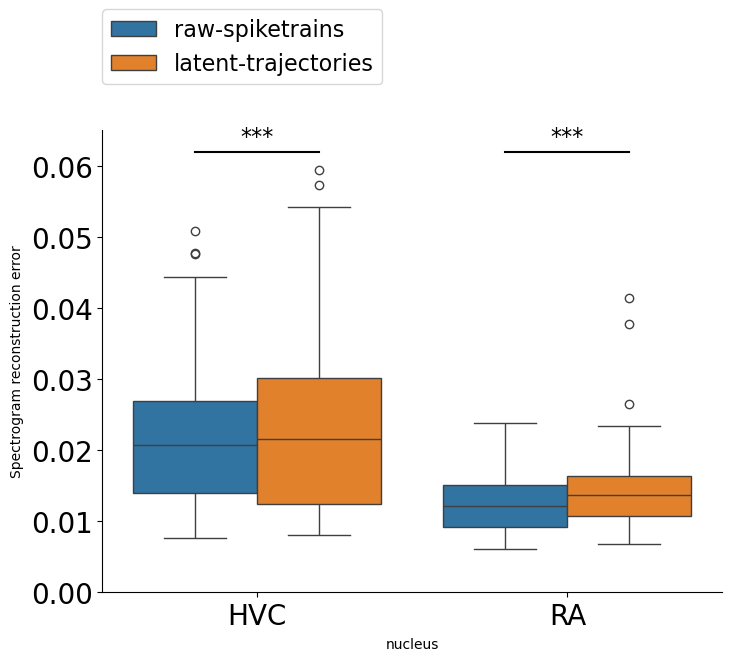

In [19]:
# Calculate statistical significance using t-test
significance = {}
for nucleus, group in decoding_accuracy_df1.groupby('model'):
    display(nucleus, group)
    hvc_error = group[group['nucleus'] == 'HVC']['Spectrogram reconstruction error'].values[0]
    ra_error = group[group['nucleus'] == 'RA']['Spectrogram reconstruction error'].values[0]
    _, p_value = stats.ttest_ind(hvc_error, ra_error)
    significance[nucleus] = p_value


# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df1.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False)

# Add significance bars
for i, p_value in enumerate(significance.values()):
    if p_value < 0.05:  # Adjust significance threshold as needed
        ax.plot([i - 0.2, i + 0.2], [0.062, 0.062], lw=1.5, c='black')  # Adjust y-coordinate and appearance as needed

# Add asterisks for statistical significance
for i, p_value in enumerate(significance.values()):
    if p_value < 0.05:  # Adjust significance threshold as needed
        plt.text(i, 0.0625, "***", ha='center', va='bottom', fontsize=16)  # Adjust position and appearance as needed



# Remove top and right spines
ax.set_ylim([0, 0.065])
ax.set_xlim([-0.5, len(significance) - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed
plt.legend(fontsize='16', loc=(0,1.1)) 

plt.show()


In [ ]:
b1ra-raw  = 015856
b2ra-raw  = 031754
b1hvc-raw = 015347
b2hvc-raw = 030450

b1ra-trj  = 020155
b2ra-trj  = 031507
b1hvc-trj = 020154
b2hvc-trj = 031418

Loading model:  z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450.pt
z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450_metadata.json
train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]  - model_layers:  [150, 64, 64, 128]
Length of neural trials: 899.9666666666667 ms, length of audio trials: 899.96 ms. 
Pre-processing neural data as RAW
Using 3 bins of neural data history.
<class 'numpy.ndarray'>
Shuffling the input data along the temporal dimension
Train samples:  4810
Test samples:  1320
Loading model:  z_r12r13_21_RAW_ra_all_FFNN_20240409_031754.pt
z_r12r13_21_RAW_ra_all_FFNN_20240409_031754_metadata.json
train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]  - model_layers:  [252, 64, 64, 

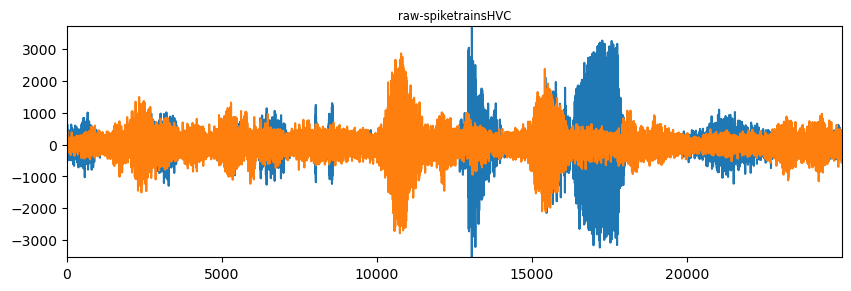

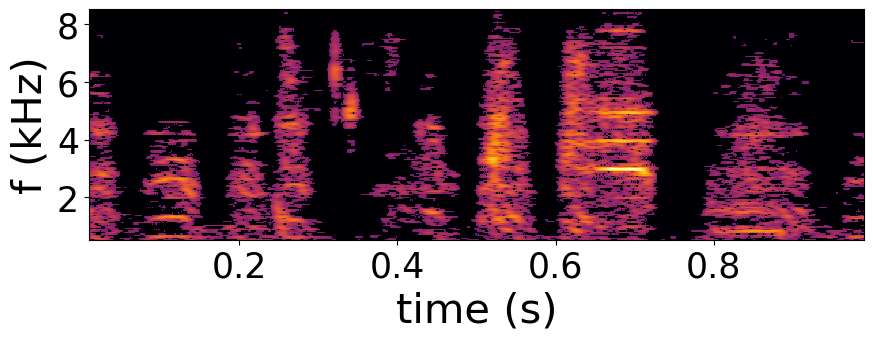

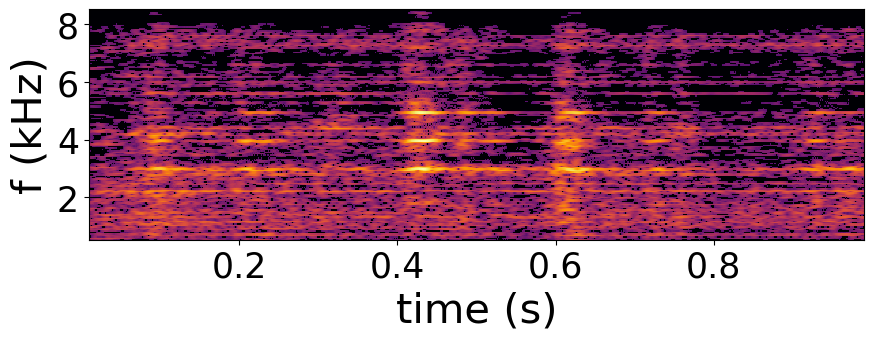

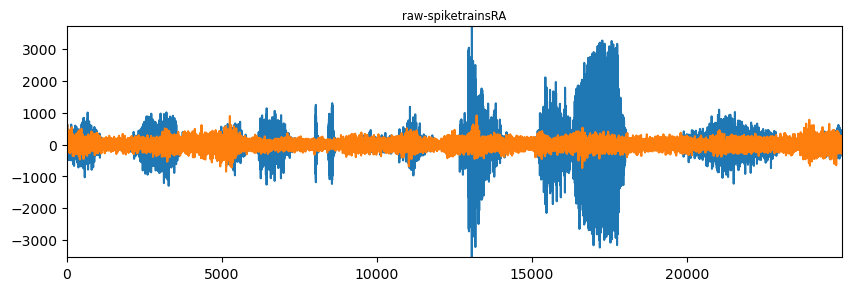

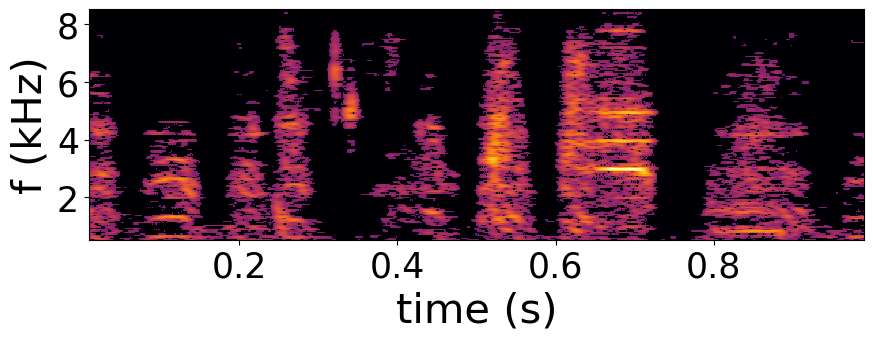

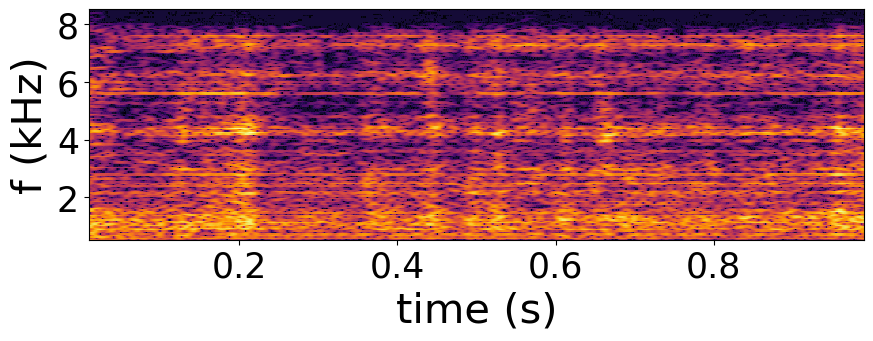

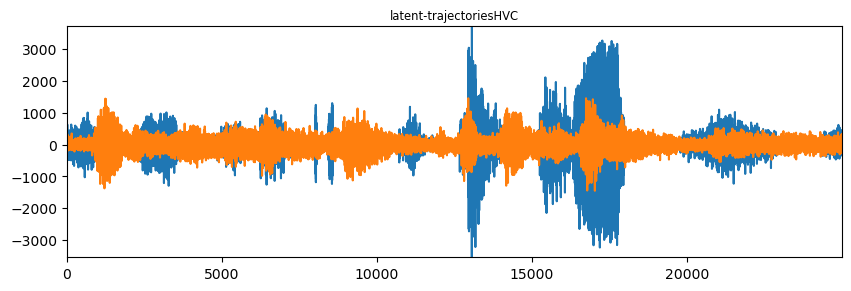

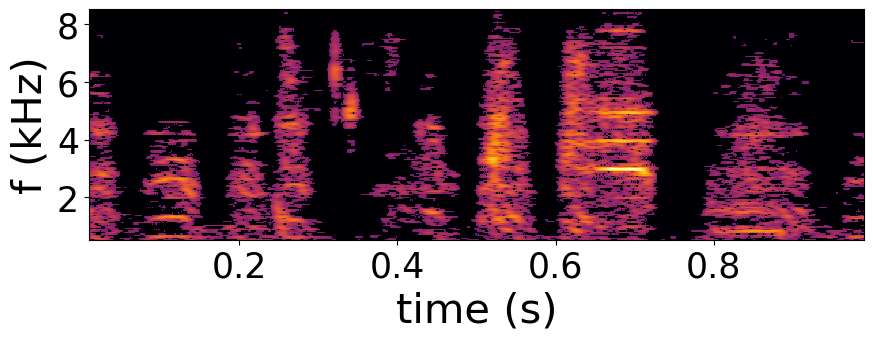

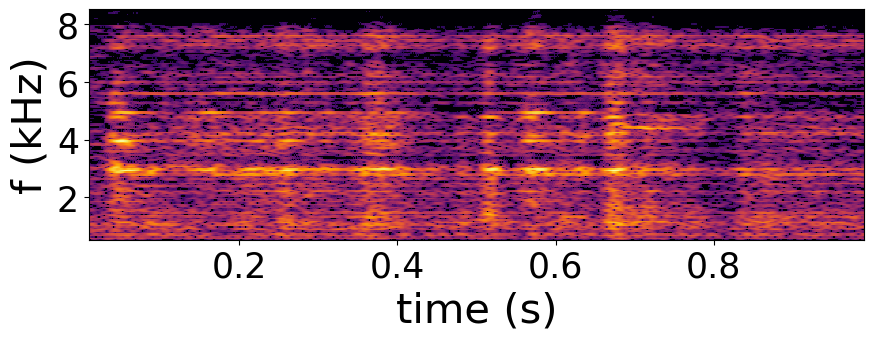

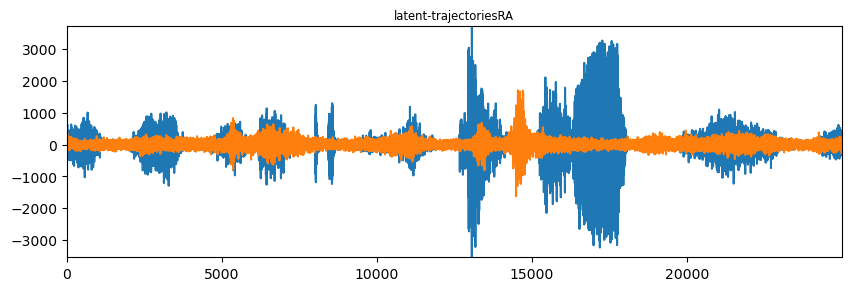

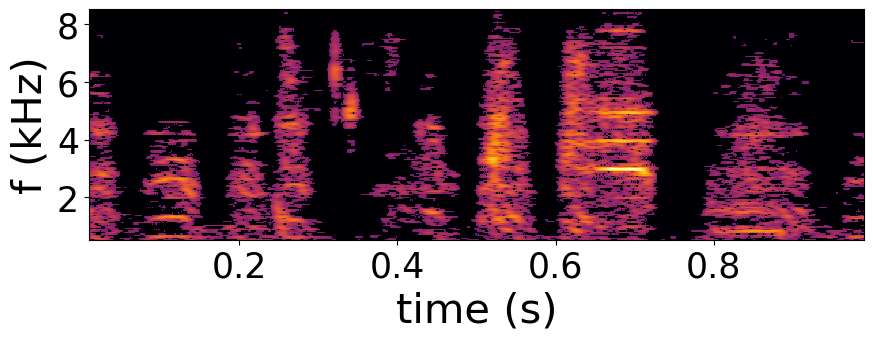

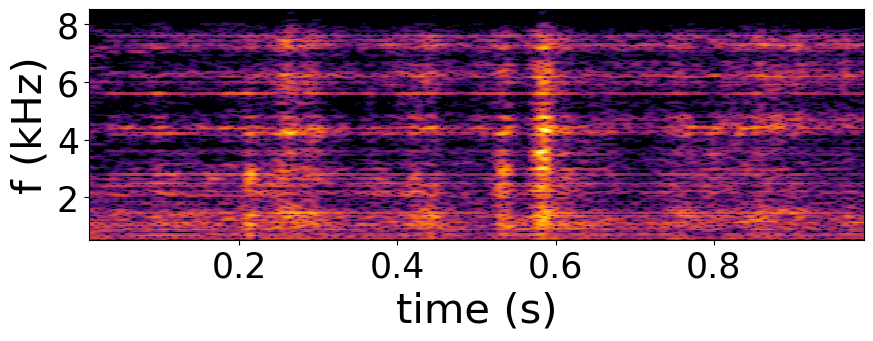

In [30]:
warnings.filterwarnings("ignore")

bird = 'z_r12r13_21'
models_dict = {
    'raw-spiketrains': {
        'HVC': '030450',
        'RA': '031754'
    },
    
    'latent-trajectories': {
        'HVC': '031418',
        'RA': '031507'
    }
}


models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/models_checkpoints/'
column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df = pd.DataFrame(columns=column_names)

for model_type in models_dict:
    for nucleus in models_dict[model_type]:

        # Load model
        model_timestamp = models_dict[model_type][nucleus]
        model_extension = '.pt'  
        model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
        model_filename = next((file for file in model_files if model_timestamp in file), None)

        print('Loading model: ', model_filename)
        ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, model_filename, suffle_inputs=True)

        # Reconstruct spectrogram
        scale = torch.mean(scales)
        original_audio, decoded_audio = get_original_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)

        # Calculate spectrogram reconstruction error
        s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
        s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
        spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
        
        decoding_accuracy_df.loc[len(decoding_accuracy_df)] = [model_filename, nucleus, model_type, spec_reconstruction_error]

        # Plot original and reconstructed
        # plot_ms = 0.05 + BSP.data[bird]['len_motif'] + 0.05
        plot_ms = 1
        plot_samples = int(plot_ms*fs_audio)
        
        fig, ax = plt.subplots(nrows=1, figsize=(10, 3))
        plt.title(model_type + nucleus)
        plt.plot(original_audio[:plot_samples])
        plt.plot(decoded_audio[:plot_samples])
    
        plot_spectrogram(original_audio, fs_audio, plot_samples)
        plot_spectrogram(decoded_audio, fs_audio, plot_samples)


'latent-trajectories'

,model_name,nucleus,model,Spectrogram reconstruction error
2,z_r12r13_21_TRAJECTORIES_hvc_all_FFNN_20240409...,HVC,latent-trajectories,"[0.03041043316680999, 0.01753391188344881, 0.0..."
3,z_r12r13_21_TRAJECTORIES_ra_all_FFNN_20240409_...,RA,latent-trajectories,"[0.025731580454800205, 0.012215674263250096, 0..."


'raw-spiketrains'

,model_name,nucleus,model,Spectrogram reconstruction error
0,z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450.pt,HVC,raw-spiketrains,"[0.02626778507321643, 0.017778199790317365, 0...."
1,z_r12r13_21_RAW_ra_all_FFNN_20240409_031754.pt,RA,raw-spiketrains,"[0.020961278085671067, 0.009517249360416119, 0..."


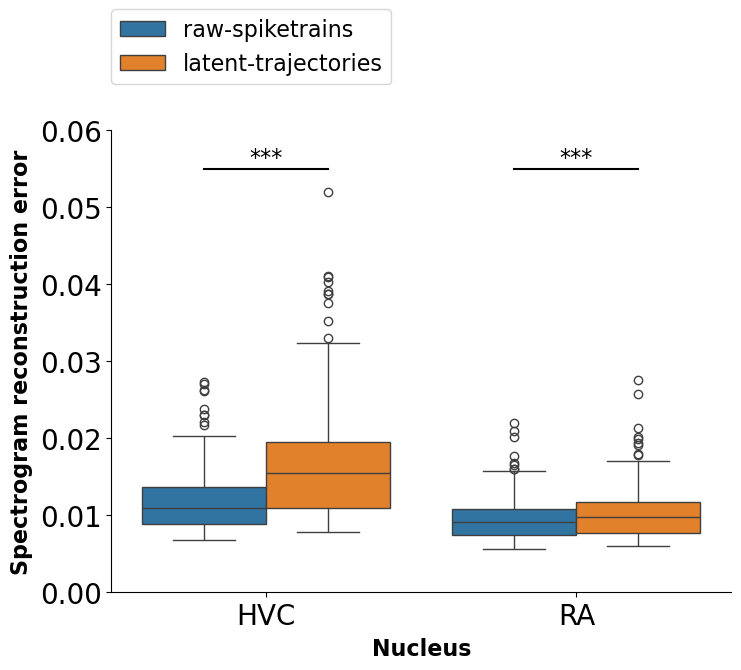

In [21]:

# Calculate statistical significance using t-test
significance = {}
for nucleus, group in decoding_accuracy_df.groupby('model'):
    display(nucleus, group)
    hvc_error = group[group['nucleus'] == 'HVC']['Spectrogram reconstruction error'].values[0]
    ra_error = group[group['nucleus'] == 'RA']['Spectrogram reconstruction error'].values[0]
    _, p_value = stats.ttest_ind(hvc_error, ra_error)
    significance[nucleus] = p_value


# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False)

# Add significance bars
for i, p_value in enumerate(significance.values()):
    if p_value < 0.05:  # Adjust significance threshold as needed
        ax.plot([i - 0.2, i + 0.2], [0.055, 0.055], lw=1.5, c='black')  # Adjust y-coordinate and appearance as needed

# Add asterisks for statistical significance
for i, p_value in enumerate(significance.values()):
    if p_value < 0.05:  # Adjust significance threshold as needed
        plt.text(i, 0.055, "***", ha='center', va='bottom', fontsize=16)  # Adjust position and appearance as needed

plt.xlabel('Nucleus', fontsize=16, fontweight='bold')
plt.ylabel(error_type, fontsize=16, fontweight='bold')

# Remove top and right spines
ax.set_ylim([0, 0.06])
ax.set_xlim([-0.5, len(significance) - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed
plt.legend(fontsize='16', loc=(0,1.1)) 

plt.show()



In [45]:
s1.shape, s1, s2.shape, s2

((3432, 256),
 array([[0.55693297, 0.51009756, 0.37362164, ..., 0.18228503, 0.12323743,
         0.18588714],
        [0.51412773, 0.35537294, 0.50300394, ..., 0.1097423 , 0.14339424,
         0.12428025],
        [0.51059673, 0.44356937, 0.48973618, ..., 0.09107181, 0.17309235,
         0.15456803],
        ...,
        [0.47542721, 0.43030203, 0.33893517, ..., 0.02582257, 0.06808247,
         0.07425608],
        [0.49562594, 0.4089771 , 0.36453413, ..., 0.06592466, 0.09163257,
         0.03586808],
        [0.50346873, 0.43085885, 0.39727223, ..., 0.18701935, 0.1963434 ,
         0.1866084 ]]),
 (3432, 256),
 array([[0.60985556, 0.58069087, 0.50358408, ..., 0.23899374, 0.22715809,
         0.23906142],
        [0.60872374, 0.56183678, 0.48542055, ..., 0.18653077, 0.09975903,
         0.18302838],
        [0.59618859, 0.52549681, 0.34973348, ..., 0.16530045, 0.15295814,
         0.1709602 ],
        ...,
        [0.57365004, 0.49022691, 0.45938309, ..., 0.15464801, 0.16215684,
      